## Implementing SVM to classify images of dogs and cats.
1=dog and 0=cat

In [5]:
import os
# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json /root/.kaggle/

# Set the appropriate permissions
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
import zipfile
import cv2
from os import listdir # list directories
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()


In [7]:
# Define the paths
train_zip_path = '/kaggle/working/train.zip'
test_zip_path = '/kaggle/working/test1.zip'
extracted_files_path = '/kaggle/working/'

# Download the dataset
api.competition_download_file('dogs-vs-cats', 'train.zip', path='/kaggle/working/')
api.competition_download_file('dogs-vs-cats', 'test1.zip', path='/kaggle/working/')


train.zip: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# Extract train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

# Extract test1.zip (if needed)
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_files_path)

# Verify the extraction
print("Train and test data extracted successfully!")

Train and test data extracted successfully!


In [9]:
# Define the path to the extracted train data
train_data_path = os.path.join(extracted_files_path, 'train')

In [10]:
# Load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        label = filename.split('.')[0]  # 'dog' or 'cat'
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize to a fixed size (e.g., 64x64)
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = load_images_from_folder(train_data_path)

In [11]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [11]:
images.shape

(25000, 64, 64, 3)

In [12]:
images

array([[[[ 75,  77,  69],
         [116, 109, 106],
         [ 82,  77,  78],
         ...,
         [115,  85,  60],
         [156, 130, 100],
         [145, 107,  72]],

        [[ 78,  85,  80],
         [117, 113, 108],
         [ 80,  79,  69],
         ...,
         [110,  83,  57],
         [175, 147, 117],
         [127,  90,  62]],

        [[ 85, 100,  90],
         [ 88,  89,  78],
         [ 84,  86,  67],
         ...,
         [110,  83,  57],
         [185, 156, 125],
         [130,  96,  83]],

        ...,

        [[ 99, 111, 129],
         [108, 120, 138],
         [110, 122, 140],
         ...,
         [ 83,  92, 105],
         [ 93, 102, 115],
         [ 95, 104, 117]],

        [[ 97, 107, 125],
         [107, 117, 135],
         [109, 119, 137],
         ...,
         [ 80,  93, 108],
         [ 77,  90, 106],
         [ 84,  97, 112]],

        [[107, 114, 133],
         [109, 116, 135],
         [101, 108, 127],
         ...,
         [ 79,  92, 108],
        

In [12]:
labels

array(['dog', 'dog', 'dog', ..., 'cat', 'cat', 'cat'], dtype='<U3')

In [13]:
# Encode labels to 0 and 1
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [27]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=1)

In [28]:
# Flatten the images
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

In [29]:
# Normalize the pixel values to [0, 1]
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

## Feature Scaling

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

In [31]:
# Apply PCA-Principal Component Analysis (PCA) to reduce the dimensionality of feature vectors before feeding them into the SVM.
from sklearn.decomposition import PCA
pca = PCA(n_components=100)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [32]:
# Ensure shapes are correct
print("Shape of X_train_features:", X_train_pca.shape)
print("Shape of X_test_features:", X_test_pca.shape)

Shape of X_train_features: (17500, 100)
Shape of X_test_features: (7500, 100)


In [33]:
# Initialize and train the SVM model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(C=1.0, random_state=1)
svm.fit(X_train_pca, y_train)

SVC(random_state=1)

In [37]:
# Predict on the test set
y_pred = svm.predict(X_test_pca)

In [38]:
# Ensure the prediction shapes are correct
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

Shape of y_test: (7500,)
Shape of y_pred: (7500,)


In [39]:
# Calculate accuracy
accuracy = accuracy_score(y_test,y_pred)

In [41]:
#Checking Accuracy
accuracy

0.6762666666666667

In [40]:
y_pred

array([1, 0, 1, ..., 1, 0, 0])

## Evaluating Model

array([[[150, 200, 212],
        [150, 200, 212],
        [153, 204, 216],
        ...,
        [ 98,  98, 103],
        [123, 140, 132],
        [ 80,  86,  80]],

       [[144, 195, 207],
        [148, 198, 210],
        [151, 202, 214],
        ...,
        [106, 106, 108],
        [137, 151, 143],
        [ 97, 107, 102]],

       [[146, 196, 208],
        [149, 199, 211],
        [150, 201, 214],
        ...,
        [105, 106, 104],
        [137, 143, 134],
        [118, 132, 130]],

       ...,

       [[ 86, 139, 161],
        [ 70, 126, 154],
        [ 86, 137, 157],
        ...,
        [ 30,  61,  88],
        [ 44,  65,  93],
        [ 43,  65,  92]],

       [[ 93, 141, 163],
        [ 71, 121, 149],
        [ 86, 132, 153],
        ...,
        [ 48,  85, 106],
        [ 50,  76,  97],
        [ 31,  58,  80]],

       [[ 73, 125, 148],
        [ 81, 133, 156],
        [ 83, 135, 158],
        ...,
        [ 36,  64,  85],
        [ 37,  55,  82],
        [ 39,  61,  92]]], dtype=uint8)
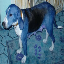

In [43]:
X_test[0]

In [45]:
#Actual
y_test[0]

1

In [46]:
#Predicted
y_pred[0]

1

## The model is predicting accurately.